In [ ]:
import urllib.request


In [ ]:
#pip uninstall pillow

In [ ]:
#pip install pillow==4.0.0

In [ ]:
#!pip install --user syft==0.2.9
#the code will show error if the syft version is 0.3.*. 

In [ ]:
def read_binary_file(file):
    f = open(file,'rb')
    block = f.read()
    return block.decode('utf-16')

def split_text_in_lines(text):
    splitTextInLines = text.split('\n')
    return splitTextInLines

def split_by_tabs(line):
    return line.split('\t')

In [ ]:
diagnosis_data = 'covid.data'

In [ ]:
import numpy as np

def parse_boolean(field):
    return 1. if field == 'yes' else 0.

def read_np_array(file = diagnosis_data):
    text = read_binary_file(file)
    lines = split_text_in_lines(text)
    rows = []
    for line in lines:
        if line == '': continue
        line = line.replace('\r\n', '')
        fields = split_by_tabs(line)
        row = []
        j = 0
        for field in fields:
            value = field
            row.append(value)
            j += 1
        rows.append(row)
    matrix = np.array(rows, dtype = np.float32)
    return matrix

In [ ]:
def get_random_indexes(n):
    indexes = list(range(n))
    random_indexes = []
    for i in range(n):
        r = np.random.randint(len(indexes))
        random_indexes.append(indexes.pop(r))
    return random_indexes

def get_indexes_for_2_datasets(n, training = 80):
    indexes = get_random_indexes(n)
    train = int(training / 100. * n)
    return indexes[:train], indexes[train:]

matrix = read_np_array()
n_samples, n_dimensions = matrix.shape

train_indexes, test_indexes = get_indexes_for_2_datasets(n_samples)
train_data = matrix[train_indexes]
test_data = matrix[test_indexes]

def print_dataset(name, data):
    print('Dataset {}. Shape: {}'.format(name, data.shape))
    print(data)

In [ ]:
print_dataset('Train', train_data)


Dataset Train. Shape: (1600, 8)
[[36.9  1.   1.  ...  0.   0.   1. ]
 [36.8  0.   0.  ...  0.   0.   0. ]
 [39.8  1.   1.  ...  0.   1.   1. ]
 ...
 [39.4  1.   1.  ...  0.   1.   1. ]
 [37.   1.   1.  ...  0.   0.   1. ]
 [39.2  0.   1.  ...  0.   1.   0. ]]


In [ ]:
print_dataset('Test', test_data)


Dataset Test. Shape: (401, 8)
[[36.8  0.   0.  ...  0.   0.   0. ]
 [41.8  0.   1.  ...  1.   1.   1. ]
 [41.6  1.   0.  ...  1.   1.   1. ]
 ...
 [37.5  1.   1.  ...  0.   0.   1. ]
 [36.3  0.   0.  ...  0.   0.   0. ]
 [39.4  0.   1.  ...  1.   1.   1. ]]


In [ ]:
#pip install tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.9.2'

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
input_size = 6
learning_rate = 0.01
num_iterations = 5000 #changed from 20000 to 5000

class LogisticRegression(torch.nn.Module):

    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, 1)
        

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [ ]:
def decide(y):
    return 1. if y >= 0.5 else 0.

decide_vectorized = np.vectorize(decide)

to_percent = lambda x: '{:.2f}%'.format(x)

In [ ]:
def compute_accuracy(model, input, output):
    prediction = model(input).data.numpy()[:, 0]
    n_samples = prediction.shape[0] + 0.
    prediction = decide_vectorized(prediction)
    equal = prediction == output.data.numpy()
    return 100. * equal.sum() / n_samples

def get_input_and_output(data):
    input = Variable(torch.tensor(data[:, :6], dtype = torch.float32))
    output1 = Variable(torch.tensor(data[:, 6], dtype = torch.float32))
    output2 = Variable(torch.tensor(data[:, 7], dtype = torch.float32))
    return input, output1, output2

In [ ]:
input, output1, output2 = get_input_and_output(train_data)
test_input, test_output1, test_output2 = get_input_and_output(test_data)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

diagnosis_title1 = 'Covid Test Positive'
diagnosis_title2 = 'True Covid Positive'


In [ ]:
def plot_graphs(diagnosis_title, losses, accuracies):
    plt.plot(losses)
    plt.title(f"{diagnosis_title} - Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    plt.plot(accuracies)
    plt.title(f"{diagnosis_title} - Training Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy (Percent %)")
    plt.show()

In [ ]:
def train_model(diagnosis_title, input, output, test_input, test_output):
    model = LogisticRegression()
    criterion = torch.nn.BCELoss(size_average=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    losses = []
    accuracies = []
    n_samples, _ = input.shape
    for iteration in range(num_iterations):
            optimizer.zero_grad()
            prediction = model(input)
           
            output = output.reshape(-1,1)
            output = output.float()
            loss = criterion(prediction, output)
            loss.backward()
            optimizer.step()
            if iteration % 500 == 0:
                train_acc = compute_accuracy(model, input, output)
                train_loss = loss.item()
                losses.append(train_loss)
                accuracies.append(train_acc)
                print('iteration={}, loss={:.4f}, train_acc={}'.format(iteration, train_loss, to_percent(train_acc)))
    plot_graphs(diagnosis_title, losses, accuracies)
    test_acc = compute_accuracy(model, test_input, test_output)
    print('\nTesting Accuracy = {}'.format(to_percent(test_acc)))
    return model

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


iteration=0, loss=8.0243, train_acc=69500.00%
iteration=500, loss=1.6910, train_acc=69500.00%
iteration=1000, loss=1.4789, train_acc=69605.00%
iteration=1500, loss=1.2546, train_acc=71875.62%
iteration=2000, loss=1.0267, train_acc=73949.38%
iteration=2500, loss=0.7983, train_acc=73975.62%
iteration=3000, loss=0.5594, train_acc=76443.12%
iteration=3500, loss=0.3987, train_acc=82178.75%
iteration=4000, loss=0.3957, train_acc=82388.75%
iteration=4500, loss=0.3942, train_acc=82283.75%


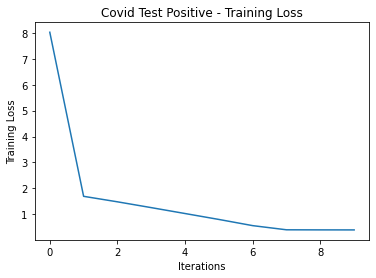

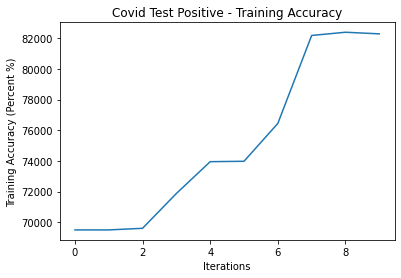


Testing Accuracy = 87.28%


In [ ]:
model = train_model(diagnosis_title1, input, output1, test_input, test_output1)


iteration=0, loss=0.5734, train_acc=87572.38%
iteration=500, loss=0.7717, train_acc=100050.12%
iteration=1000, loss=0.5824, train_acc=99812.00%
iteration=1500, loss=0.4512, train_acc=99907.25%
iteration=2000, loss=0.3410, train_acc=102050.38%
iteration=2500, loss=0.3237, train_acc=103336.25%
iteration=3000, loss=0.3183, train_acc=103336.25%
iteration=3500, loss=0.3145, train_acc=103098.12%
iteration=4000, loss=0.3117, train_acc=103002.88%
iteration=4500, loss=0.3097, train_acc=102812.38%


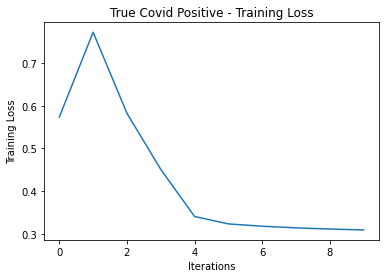

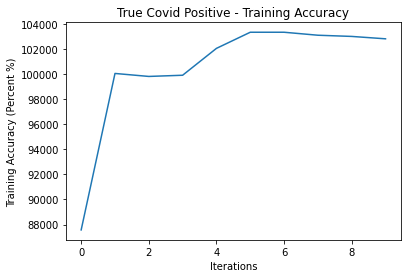


Testing Accuracy = 87.78%


In [ ]:
model = train_model(diagnosis_title2, input, output2, test_input, test_output2)


In [ ]:
pip install --user syft==0.2.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 433 kB 4.2 MB/s 
     |████████████████████████████████| 126 kB 51.0 MB/s 
     |████████████████████████████████| 73 kB 2.3 MB/s 
     |████████████████████████████████| 66 kB 4.2 MB/s 
     |████████████████████████████████| 26.0 MB 1.3 MB/s 
     |████████████████████████████████| 753.4 MB 16 kB/s 
     |████████████████████████████████| 4.0 MB 45.6 MB/s 
     |████████████████████████████████| 1.8 MB 49.4 MB/s 
     |████████████████████████████████| 78 kB 6.4 MB/s 
     |████████████████████████████████| 20.6 MB 1.2 MB/s 
     |████████████████████████████████| 449 kB 63.4 MB/s 
     |████████████████████████████████| 200 kB 73.8 MB/s 
     |████████████████████████████████| 9.0 MB 37.5 MB/s 
     |████████████████████████████████| 484 kB 61.4 MB/s 
     |████████████████████████████████| 2.0 MB 54.7 MB/s 
     |████████████████████████████████

In [ ]:
import syft as sy
import torch as th
hook = sy.TorchHook(th)
from torch import nn, optim


ModuleNotFoundError: ignored

In [ ]:
n_hospitals = 8
hospitals = []


In [ ]:
for i in range(n_hospitals):
    hospital_name = 'hospital{}'.format(i)
    hospital = sy.VirtualWorker(hook, id = hospital_name)
    hospitals.append(hospital)
secure_worker = sy.VirtualWorker(hook, id="secure_worker")

In [ ]:
def get_workers_names(workers):
    return [worker.id for worker in workers]

def add_and_print_workers(worker, workers):
    print('workers of {} = {}'.format(worker.id, get_workers_names(workers)))
    worker.add_workers(workers)

for i in range(n_hospitals):
    workers = [hospitals[i2] for i2 in range(n_hospitals) if i2 != i] + [secure_worker]
    add_and_print_workers(hospitals[i], workers)
add_and_print_workers(secure_worker, hospitals)

workers of hospital0 = ['hospital1', 'hospital2', 'hospital3', 'hospital4', 'hospital5', 'hospital6', 'hospital7', 'secure_worker']
workers of hospital1 = ['hospital0', 'hospital2', 'hospital3', 'hospital4', 'hospital5', 'hospital6', 'hospital7', 'secure_worker']
workers of hospital2 = ['hospital0', 'hospital1', 'hospital3', 'hospital4', 'hospital5', 'hospital6', 'hospital7', 'secure_worker']
workers of hospital3 = ['hospital0', 'hospital1', 'hospital2', 'hospital4', 'hospital5', 'hospital6', 'hospital7', 'secure_worker']
workers of hospital4 = ['hospital0', 'hospital1', 'hospital2', 'hospital3', 'hospital5', 'hospital6', 'hospital7', 'secure_worker']
workers of hospital5 = ['hospital0', 'hospital1', 'hospital2', 'hospital3', 'hospital4', 'hospital6', 'hospital7', 'secure_worker']
workers of hospital6 = ['hospital0', 'hospital1', 'hospital2', 'hospital3', 'hospital4', 'hospital5', 'hospital7', 'secure_worker']
workers of hospital7 = ['hospital0', 'hospital1', 'hospital2', 'hospital3', 

In [ ]:
n_samples = train_data.shape[0]
samples_per_hospital = int((n_samples + 0.5) / n_hospitals)
hospital_features = []
hospital_targets1 = []
hospital_targets2 = []
train_data = th.tensor(train_data, dtype = torch.float32, requires_grad=True)
for i in range(n_hospitals):
    train_data2 = train_data[i * samples_per_hospital:(i + 1) * samples_per_hospital].clone().detach().requires_grad_(True)
    features = train_data2[:, :6].clone().detach().requires_grad_(True)
    targets1 = train_data2[:, 6][:, None].clone().detach() 
    targets2 = train_data2[:, 7][:, None].clone().detach() 
    hospital_features.append(features.send(hospitals[i]))
    hospital_targets1.append(targets1.send(hospitals[i]))
    hospital_targets2.append(targets2.send(hospitals[i]))

print(model)

NameError: ignored

In [ ]:
def plot_federated_graphs(diagnosis_title, losses, accuracies):
    for i in range(n_hospitals):
        plt.plot(losses[i], label=f'Hospital {i}')
    legend = plt.legend(loc='upper right', shadow=True)
    plt.title(f"{diagnosis_title} - Training Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    for i in range(n_hospitals):
        plt.plot(accuracies[i], label=f'Hospital {i}')
    legend = plt.legend(loc='lower right', shadow=True)
    plt.title(f"{diagnosis_title} - Training Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy (Percent %)")
    plt.show()

In [ ]:
def compute_federated_accuracy(model, input, output):
    prediction = model(input)
    n_samples = prediction.shape[0]
    s = 0.
    for i in range(n_samples):
        p = 1. if prediction[i] >= 0.5 else 0.
        e = 1. if p == output[i] else 0.
        s += e
    return 100. * s / n_samples

iterations = 500 # changed from 1000 to 500, 2000 was the original value
worker_iterations = 14 #changed from 5 to 14

In [ ]:
def federated_learning(diagnosis_title, hospital_features, hospital_targets, test_input, test_output):
    model = LogisticRegression()
    criterion = torch.nn.BCELoss(size_average=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  
    losses = [[] for i in range(n_hospitals)]
    accuracies = [[] for i in range(n_hospitals)]
    for iteration in range(iterations):
        models = [model.copy().send(hospitals[i]) for i in range(n_hospitals)]
        optimizers = [torch.optim.SGD(params = models[i].parameters(), lr = learning_rate) for i in range(n_hospitals)]
        for worker_iteration in range(worker_iterations):
            last_losses = []
            for i in range(n_hospitals):
                optimizers[i].zero_grad()
                prediction = models[i](hospital_features[i])
                loss = criterion(prediction, hospital_targets[i])
                loss.backward()
                optimizers[i].step()
                loss = loss.get().data.item()
                last_losses.append(loss)
        for i in range(n_hospitals):
            losses[i].append(last_losses[i])
            train_acc = compute_federated_accuracy(models[i], hospital_features[i], hospital_targets[i])
            accuracies[i].append(train_acc)
            models[i].move(secure_worker)
        with th.no_grad():
            avg_weight = sum([models[i].linear.weight.data for i in range(n_hospitals)]) / n_hospitals
            model.linear.weight.set_(avg_weight.get())
            avg_bias = sum([models[i].linear.bias.data for i in range(n_hospitals)]) / n_hospitals
            model.linear.bias.set_(avg_bias.get())
        if iteration % 100 == 0:
            losses_str = ['{:.4f}'.format(losses[i][-1]) for i in range(n_hospitals)]
            accuracies_str = [to_percent(accuracies[i][-1]) for i in range(n_hospitals)]
            print('Iteration={}, losses={}, accuracies={}'.format(iteration, losses_str, accuracies_str))
    plot_federated_graphs(diagnosis_title, losses, accuracies)
    test_acc = compute_accuracy(model, test_input, test_output)
    print('\nTesting Accuracy = {}'.format(to_percent(test_acc)))
    return model

Iteration=0, losses=['2.1342', '2.1801', '2.1399', '2.0066', '2.1001', '2.1847', '2.0889', '2.1897'], accuracies=['43.00%', '42.00%', '43.50%', '53.00%', '46.00%', '47.50%', '46.50%', '48.50%']
Iteration=100, losses=['1.9253', '1.9477', '1.9286', '1.9398', '1.9459', '1.9536', '1.9446', '1.9831'], accuracies=['43.00%', '42.00%', '41.00%', '55.50%', '46.00%', '41.00%', '46.50%', '41.00%']
Iteration=200, losses=['1.5799', '1.5738', '1.5298', '1.5339', '1.6983', '1.5319', '1.7161', '1.6079'], accuracies=['43.00%', '41.50%', '41.00%', '43.00%', '46.00%', '42.00%', '46.50%', '42.00%']
Iteration=300, losses=['1.3499', '1.3166', '1.2766', '1.2885', '1.4740', '1.2815', '1.4866', '1.3698'], accuracies=['45.00%', '42.50%', '45.00%', '54.00%', '45.50%', '48.50%', '46.50%', '42.00%']
Iteration=400, losses=['1.1223', '1.0329', '1.0280', '1.0616', '1.2481', '1.0351', '1.2523', '1.1219'], accuracies=['56.00%', '61.00%', '59.50%', '54.00%', '48.50%', '58.50%', '46.00%', '61.00%']
Iteration=500, losses=

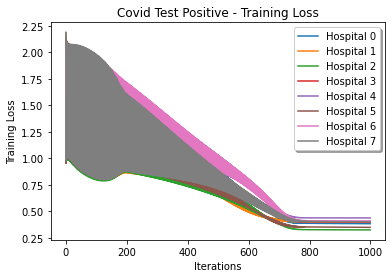

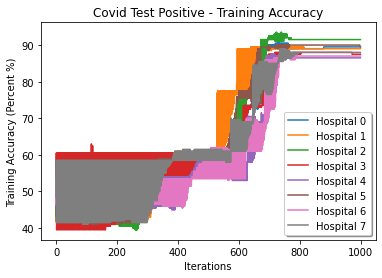


Testing Accuracy = 86.28%


In [ ]:
model = federated_learning(diagnosis_title1, hospital_features, hospital_targets1, test_input, test_output1)


In [ ]:
model = federated_learning(diagnosis_title2, hospital_features, hospital_targets2, test_input, test_output2)

NameError: ignored